In [1]:
import cv2
import torch
import imutils
import time
import numpy as np
import sys
import dlib

from os.path import join, dirname, abspath
from PIL import Image

import matplotlib.pyplot as plt


In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

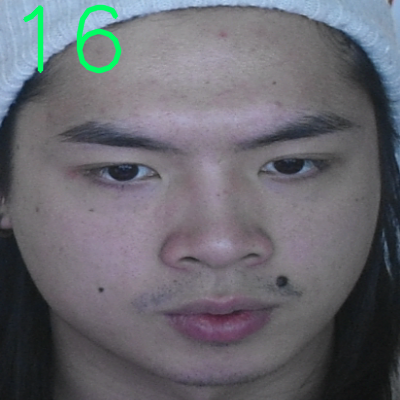

In [3]:
path = 'my-image.png'
img = Image.open(path)
#img.size
img

In [12]:
class FaceAlignment():         
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')
    
    def shape_to_normal(self, shape):
        shape_normal = []
        for i in range(0, 5):
            shape_normal.append((i, (shape.part(i).x, shape.part(i).y)))
        return shape_normal
    
    def get_eyes_nose_dlib(self, shape):
        nose = shape[4][1]
        left_eye_x = int(shape[3][1][0] + shape[2][1][0]) // 2
        left_eye_y = int(shape[3][1][1] + shape[2][1][1]) // 2
        right_eyes_x = int(shape[1][1][0] + shape[0][1][0]) // 2
        right_eyes_y = int(shape[1][1][1] + shape[0][1][1]) // 2
        return nose, (left_eye_x, left_eye_y), (right_eyes_x, right_eyes_y)

    def distance(self, a, b):
        return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    def cosine_formula(self, length_line1, length_line2, length_line3):
        cos_a = -(length_line3 ** 2 - length_line2 ** 2 - length_line1 ** 2) / (2 * length_line2 * length_line1)
        return cos_a


    def is_between(self, point1, point2, point3, extra_point):
        c1 = (point2[0] - point1[0]) * (extra_point[1] - point1[1]) - (point2[1] - point1[1]) * (extra_point[0] - point1[0])
        c2 = (point3[0] - point2[0]) * (extra_point[1] - point2[1]) - (point3[1] - point2[1]) * (extra_point[0] - point2[0])
        c3 = (point1[0] - point3[0]) * (extra_point[1] - point3[1]) - (point1[1] - point3[1]) * (extra_point[0] - point3[0])
        if (c1 < 0 and c2 < 0 and c3 < 0) or (c1 > 0 and c2 > 0 and c3 > 0):
            return True
        else:
            return False
        
    def rotate_point(self, origin, point, angle):
            ox, oy = origin
            px, py = point

            qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
            qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
            return qx, qy
        
    def align(self, image):
        img = image

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        rects = self.detector(gray, 0)
        if len(rects) > 0:
            for rect in rects:
                x = rect.left()
                y = rect.top()
                w = rect.right()
                h = rect.bottom()
                shape = self.predictor(gray, rect)
        print(shape)
        shape = self.shape_to_normal(shape)
        nose, left_eye, right_eye = self.get_eyes_nose_dlib(shape)

        center_of_forehead = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
        center_pred = (int((x + w) / 2), int((y + y) / 2))

        length_line1 = self.distance(center_of_forehead, nose)
        length_line2 = self.distance(center_pred, nose)
        length_line3 = self.distance(center_pred, center_of_forehead)

        cos_a = self.cosine_formula(length_line1, length_line2, length_line3)
        angle = np.arccos(cos_a)

        rotated_point = self.rotate_point(nose, center_of_forehead, angle)
        rotated_point = (int(rotated_point[0]), int(rotated_point[1]))
        
        if self.is_between(nose, center_of_forehead, center_pred, rotated_point):
            angle = np.degrees(-angle)
        else:
            angle = np.degrees(angle)

        aligned_img = Image.fromarray(img)
        aligned_img = np.array(aligned_img.rotate(angle))       
        return aligned_img

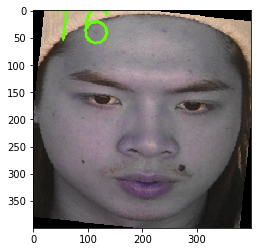

In [13]:
path = 'my-image.png'

src = cv2.imread(path)

fa = FaceAlignment()
img = fa.align(src)

plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
absolute_dir = dirname(abspath(__file__))
PROTO_TXT = join(absolute_dir, "model", "deploy.prototxt")
MODEL = join(absolute_dir, "model", "res10_300x300_ssd_iter_140000.caffemodel")
THRESHOLD = 0.5

def face_detection(callback=None):
    net = cv2.dnn.readNetFromCaffe(PROTO_TXT, MODEL)

    prev_frame_time = 0
    new_frame_time = 0
    access = 0

    cam = cv2.VideoCapture(0)
    while True:
        _, frame = cam.read()
        
        h, w = frame.shape[:2]
        
        blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        net.setInput(blob)
        detections = net.forward()
        for i in np.arange(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            
            if confidence < THRESHOLD:
                continue
            
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            start_x , start_y, end_x, end_y = box.astype("int")
                
            color =(255, 0, 0)
            stroke = 3
            cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), color, stroke)
            #frame = crop_img(frame, start_x-20, start_y-20, end_x+20, end_y+20)
            

            if callback:
                tensor = callback(frame)
                print(tensor.shape)
                print(tensor)
                cam.release()
                cv2.destroyAllWindows()
                return


        new_frame_time = time.time()
        fps = 1 / (new_frame_time - prev_frame_time)
        prev_frame_time = new_frame_time
        fps = str(int(fps))
        cv2.putText(frame, fps, (7, 70), cv2.FONT_HERSHEY_SIMPLEX, 3, (100, 255, 0), 3, cv2.LINE_AA)

        if cv2.waitKey(20) & 0xFF == ord('1'):
            access = 1
        if cv2.waitKey(20) & 0xFF == ord('2'):
            access = 2
        if cv2.waitKey(20) & 0xFF == ord('3'):
            access = 0

        if access == 1:
            cv2.putText(frame, "User recognized - Access Granted!", (10, 1000), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 3, cv2.LINE_AA)#, bottomLeftOrigin=True)
        elif access == 2:
            cv2.putText(frame, "User not recognized - Access Denied!", (10, 1000), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 3, cv2.LINE_AA)#, bottomLeftOrigin=True)

        cv2.imshow('Webcam', frame)
        #img_item = "my-image.png"
        #cv2.imwrite(img_item, frame)

        if cv2.waitKey(20) & 0xFF == 27:#ord('q'):
            break

    cam.release()
    cv2.destroyAllWindows()


def detect(image, net):
    blob = cv2.dnn.blobFromImage(image, 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    return detections


def crop_img(img, start_x, start_y, end_x, end_y):
    height, width = end_y - start_y, end_x - start_x
    crop_img = img[start_y:start_y+height, start_x:start_x+width]
    crop_img = cv2.resize(crop_img, (400, 400))
    return crop_img


if __name__ == '__main__':
    face_detection()
    sys.exit(0)
    